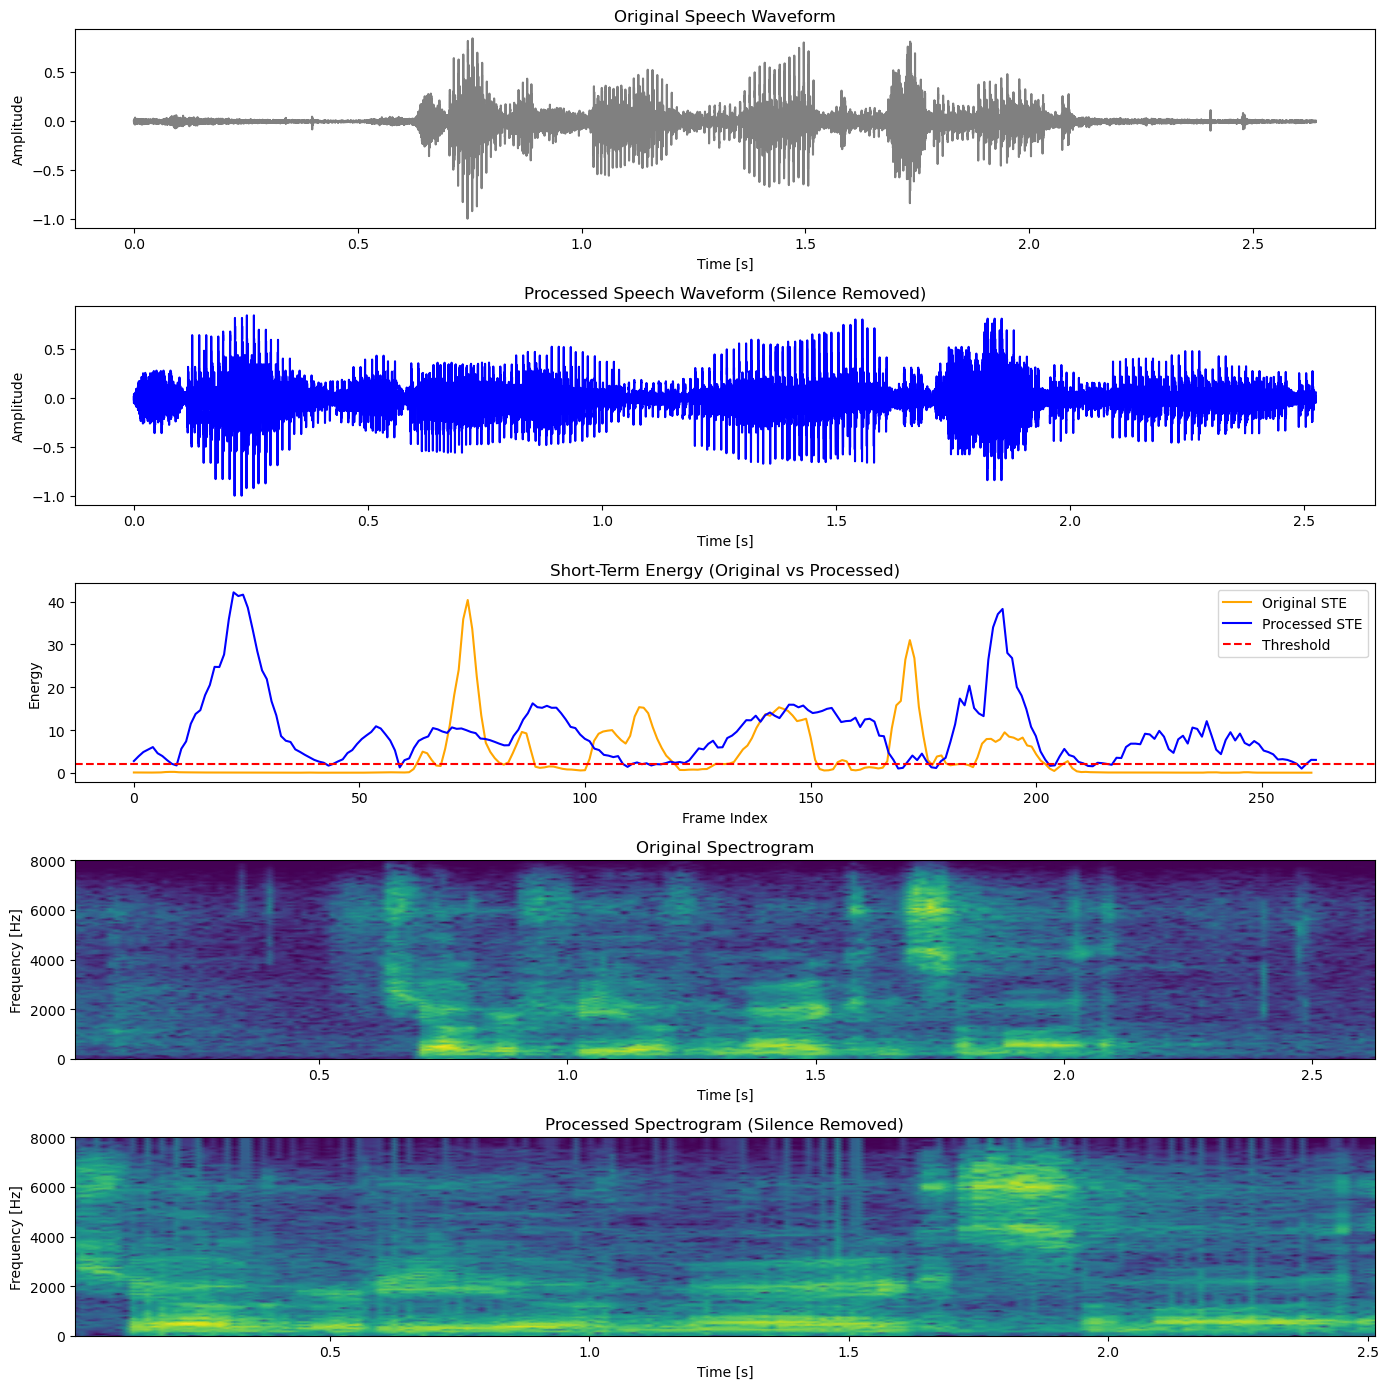

In [ ]:
#credit to drew
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram
import os

# === Step 1: Load the WAV file ===
file_path = r"C:\Users\drewe\OneDrive - University of Wisconsin - Platteville\UndergradResearch\nchlt_eng\audio\001\nchlt_eng_001m_0003.wav"

# Verify file exists"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")

sample_rate, signal = wavfile.read(file_path)

# If stereo, convert to mono
if signal.ndim > 1:
    signal = signal.mean(axis=1)

# Normalize to [-1, 1]
signal = signal / np.max(np.abs(signal))

# === Step 2: Compute Short-Term Energy (STE) ===
frame_size = int(0.025 * sample_rate)  # 25 ms
hop_size = int(0.010 * sample_rate)    # 10 ms hop

energy = []
for start in range(0, len(signal) - frame_size, hop_size):
    frame = signal[start:start + frame_size]
    energy.append(np.sum(frame ** 2))

energy = np.array(energy)

# === Step 3: Silence Removal ===
threshold = 0.05 * np.max(energy)  # Tune as needed
speech_frames = energy > threshold

# Reconstruct the non-silent signal
new_signal = []
for i, keep in enumerate(speech_frames):
    if keep:
        start = i * hop_size
        new_signal.extend(signal[start:start + frame_size])
new_signal = np.array(new_signal)

# Compute new short-term energy for processed signal
new_energy = []
for start in range(0, len(new_signal) - frame_size, hop_size):
    frame = new_signal[start:start + frame_size]
    new_energy.append(np.sum(frame ** 2))
new_energy = np.array(new_energy)

# === Step 4: Compute Spectrograms ===
f1, t1, Sxx1 = spectrogram(signal, sample_rate)
f2, t2, Sxx2 = spectrogram(new_signal, sample_rate)

# === Step 5: Plot All Results ===
plt.figure(figsize=(14, 14))

# (1) Original waveform
plt.subplot(5, 1, 1)
time = np.arange(len(signal)) / sample_rate
plt.plot(time, signal, color='gray')
plt.title("Original Speech Waveform")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

# (2) Processed waveform (silence removed)
plt.subplot(5, 1, 2)
new_time = np.arange(len(new_signal)) / sample_rate
plt.plot(new_time, new_signal, color='blue')
plt.title("Processed Speech Waveform (Silence Removed)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

# (3) Short-term energy comparison
plt.subplot(5, 1, 3)
plt.plot(energy, label="Original STE", color='orange')
plt.plot(np.linspace(0, len(energy), len(new_energy)), new_energy, label="Processed STE", color='blue')
plt.axhline(y=threshold, color='red', linestyle='--', label="Threshold")
plt.title("Short-Term Energy (Original vs Processed)")
plt.xlabel("Frame Index")
plt.ylabel("Energy")
plt.legend()

# (4) Spectrogram of original
plt.subplot(5, 1, 4)
plt.pcolormesh(t1, f1, 10 * np.log10(Sxx1 + 1e-10), shading='gouraud')
plt.title("Original Spectrogram")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")

# (5) Spectrogram of processed
plt.subplot(5, 1, 5)
plt.pcolormesh(t2, f2, 10 * np.log10(Sxx2 + 1e-10), shading='gouraud')
plt.title("Processed Spectrogram (Silence Removed)")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")

plt.tight_layout()
plt.show()
